In [356]:
from femtoPy.imports import *
import scipy.signal as sgn
import numpy.fft as fft
import time

'class to hold populations and coherent evolution equations for the density matrix'
class densityMatrix:
    'constructor'
    def __init__(self,t=np.linspace(-1,1,100),Ek=np.ones(1),d=np.ones(1),DOS=np.ones(1),Coul_scale=1e-3):
        self.fe=np.zeros((Ek.size,t.size),dtype=complex)     # electron density
        self.fh=np.zeros((Ek.size,t.size),dtype=complex)     # hole density
        self.P=np.zeros((Ek.size,t.size),dtype=complex)      # polarization
        self.d=d       # dipole moment
        self.Ek=Ek     # energy separation
        self.DOS=DOS   # density of states
        self.P_renorm=0  # coulomb interaction for P
        self.f_renorm=0  # coulomb interaction for f
        self.Coul_scale=Coul_scale  # scale of Coulomb interaction
        
        self.C_weight=np.zeros((Ek.size,Ek.size))
        for i in range(k.size):
            self.C_weight[i,:i]=k[:i]*np.log((k[:i]+k[i])**2/(k[:i]-k[i])**2)/2/k[i]
            self.C_weight[i,i+1:]=k[i+1:]*np.log((k[i+1:]+k[i])**2/(k[i+1:]-k[i])**2)/2/k[i]
        
        return
    
    'coherent evolution of polarization'
    def pCoh(self,i,E,w0):
        dP=(self.Ek-w0-self.f_renorm)*self.P[:,i]-(1-self.fe[:,i]-self.fh[:,i])*(self.d*E[i]+self.P_renorm)
        
        return -1j*dP
    
    'coherent evolution of electron population'
    def feCoh(self,i,E):
        return 2*self.d*np.imag(self.P[:,i]*(E[i]+np.conjugate(self.P_renorm)))
    
    'coherent evolution of hole population'
    def fhCoh(self,i,E):
        return 2*self.d*np.imag(self.P[:,i]*(E[i]+np.conjugate(self.P_renorm)))
    
    def calcP(self,t,w0):
        'sum polarization along energy axis'
        Pt1=np.dot(self.DOS,self.P)
        Pt1=Pt1*np.exp(-1j*w0*t)
        self.Pt=np.real(Pt1+np.conjugate(Pt1))/2.
        
        'transform polarization'
        self.Pw=fft.fftshift(fft.fft(self.Pt))
        
        return self.Pt,self.Pw
    
    def PEnv(self):
        return np.absolute(np.sum(self.P,axis=0))
    
    'execute time step given value of derivative'
    def update(self,dt,dP,dfe,dfh,i):
        self.P[:,i+1]=self.P[:,i]+dP*dt
        self.fe[:,i+1]=self.fe[:,i]+dfe*dt
        self.fh[:,i+1]=self.fh[:,i]+dfh*dt
        
        return
    
    'calculate hartree-fock renormalizations'
    def renorm(self,k,i):
#         self.f_renorm=self.Coulomb(k,self.fe[:,i]+self.fh[:,i])
        self.P_renorm=np.dot(self.C_weight,self.P[:,i])*self.Coul_scale
#         self.fe_renorm=np.dot(self.C_weight,self.fe[:,i])
#         self.fh_renorm=np.dot(self.C_weight,self.fh[:,i])

        return


'update function (fourth order runge kutta)'
def update(rho,E,w0):
    rho.renorm(k,i)
    dP1=rho.pCoh(i,E,w0)+pScat(rho,i)
#     dfe1=rho.feCoh(i,E)+feScat(rho,i)
#     dfh1=rho.fhCoh(i,E)+fhScat(rho,i)

#     rho.update(dt/2.,dP1,dfe1,dfh1,i)
    rho.update(dt/2.,dP1,0,0,i)
#     rho.renorm(k,i+1)
    
    dP2=rho.pCoh(i+1,E,w0)+pScat(rho,i+1)
#     dfe2=rho.feCoh(i+1,E)+feScat(rho,i+1)
#     dfh2=rho.fhCoh(i+1,E)+fhScat(rho,i+1)
    
#     rho.update(dt/2.,dP2,dfe2,dfh2,i)
    rho.update(dt/2.,dP2,0,0,i)
#     rho.renorm(k,i+1)
    
    dP3=rho.pCoh(i+1,E,w0)+pScat(rho,i+1)
#     dfe3=rho.feCoh(i+1,E)+feScat(rho,i+1)
#     dfh3=rho.fhCoh(i+1,E)+fhScat(rho,i+1)
    
#     rho.update(dt,dP3,dfe3,dfh3,i)
    rho.update(dt,dP3,0,0,i)
#     rho.renorm(k,i+1)
    
    dP4=rho.pCoh(i+1,E,w0)+pScat(rho,i+1)
#     dfe4=rho.feCoh(i+1,E)+feScat(rho,i+1)
#     dfh4=rho.fhCoh(i+1,E)+fhScat(rho,i+1)
    
    dP=(dP1+2*dP2+2*dP3+dP4)/6
#     dfe=(dfe1+2*dfe2+2*dfe3+dfe4)/6
#     dfh=(dfh1+2*dfh2+2*dfh3+dfh4)/6
    
    rho.update(dt,dP,0,0,i)
#     rho.renorm(k,i+1)
    
    return

def trim(f,E,P,Emin=0.00001,split=True):
    # if only positive frequencies are required
    if split:
        E=E[int(E.size/2):]
        P=P[int(P.size/2):]
        f=f[int(f.size/2):]
        loc1=np.amin(np.where(np.absolute(E) < Emin))
        loc2=np.amax(np.where(np.absolute(E) > Emin))
        E=E[loc1:loc2]
        P=P[loc1:loc2]
        f=f[loc1:loc2]
    # if negative frequencies are required as well
    else:
        loc1=np.amin(np.where(np.absolute(E) > Emin))
        loc2=np.amax(np.where(np.absolute(E) > Emin))
        
        E=E[loc1:loc2]
        P=P[loc1:loc2]
        f=f[loc1:loc2]

    return f,E,P

def chi(w,w0,tau,scale):
    e=1/(w0*w0-w*w-1j*w/tau)
    e1=np.real(e)
    e2=np.imag(e)
    scale=scale/np.amax(e2)

    return e1*scale,e2*scale

'two-level system scattering functions'
def pScat(rho,i):
    return -rho.P[:,i]/tau2
def feScat(rho,i):
    return -rho.fe[:,i]/tau1
def fhScat(rho,i):
    return -rho.fe[:,i]/tau1

def adjAvg2D(X,Y,dat):
    buf=np.ndarray((int(dat[:,0].size/2),int(dat[0,:].size)),dtype=complex)
    xbuf=np.ndarray(int(X.size/2))
    ybuf=np.ndarray(int(Y.size/2))
    for i in range(buf[:,0].size):
        xbuf[i]=(X[2*i]+X[2*i+1])/2.
        buf[i,:]=(dat[2*i,:]+dat[2*i+1,:])/2.
        
    buf2=np.ndarray((int(buf[:,0].size),int(buf[0,:].size/2)),dtype=complex)
    for i in range(buf2[0,:].size):
        ybuf[i]=(Y[2*i]+Y[2*i+1])/2.
        buf2[:,i]=(buf[:,2*i]+buf[:,2*i+1])/2
        
    return xbuf,ybuf,buf2
     
%matplotlib inline

# %load_ext Cython

# Hartree Fock

In [462]:
'scattering times'
tau1=10
tau2=1

'E-field for simulation'
tmin=-3
tmax=60
dt=.0005
t=np.arange(tmin,tmax,dt)

np.seterr(under='ignore')
E=0.01*np.exp(-15*t*t)
w0=20
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))
Ew=fft.fftshift(fft.fft(np.real(E*(np.exp(1j*w0*t)+np.exp(-1j*w0*t))/2)))
# Ew=fft.fftshift(fft.fft(np.real(E*(np.exp(1j*w0*t)))))
 
'Density matrices'
k=np.linspace(0.01,7,400)
Ek=k*k+18
d=np.zeros(k.size)+0.01
DOS=(k*k)/100
rho=densityMatrix(t,Ek,d,DOS=DOS,Coul_scale=2e-2)

t0=time.time()
# fig,ax=figure()
'step simulation'
for i in range(0,t.size-1):
    update(rho,E,w0)
    if i%5000==0 and i > 3:
        print('step '+str(i)+'/'+str(t.size))
        print(time.time()-t0)


'calculate polarization'
Pt,Pw=rho.calcP(t,w0)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(np.absolute(Ew))/100,split=False)

'calculate susceptibility'
Chi=np.conjugate(Pw/Ew)

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

step 5000/126000
7.58318018913269
step 10000/126000
14.922712326049805
step 15000/126000
22.183244705200195
step 20000/126000
29.72626757621765
step 25000/126000
36.965481758117676
step 30000/126000
44.313411235809326
step 35000/126000
51.604159355163574
step 40000/126000
58.89605975151062
step 45000/126000
66.17116498947144
step 50000/126000
73.43773484230042
step 55000/126000
80.70342516899109
step 60000/126000
87.97588920593262
step 65000/126000
95.25879502296448
step 70000/126000
102.62798142433167
step 75000/126000
109.99330878257751
step 80000/126000
117.359121799469
step 85000/126000
124.86773133277893
step 90000/126000
132.1848328113556
step 95000/126000
139.5421051979065
step 100000/126000
146.85246324539185
step 105000/126000
154.21869611740112
step 110000/126000
161.87970209121704
step 115000/126000
169.33758974075317
step 120000/126000
176.77965569496155
step 125000/126000
184.1855845451355


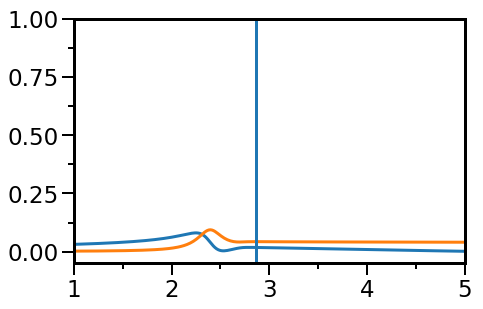

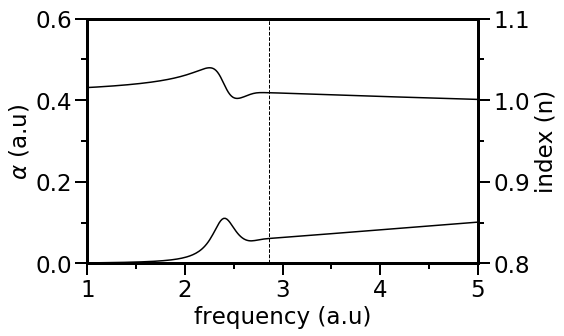

In [463]:
'plot alpha'
fig,ax=figure(figsize=(7,4.5))
ax.plot(f,np.real(Chi))
ax.set_xlim(1,5)
ax.set_ylim(-0.05,1)
ax.plot(f,np.imag(Chi))

ax.axvline(18/2/np.pi)

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure(figsize=(7,4.5))
ax1=ax.twinx()
minorTicker(ax1)

ax1.plot(f,n,color='k',linewidth=1.5)
ax.plot(f,alpha,color='k',linewidth=1.5)

ax.set_xlim(1,5)
ax1.set_ylim(0.8,1.1)
ax.set_ylim(0,0.6)

ax.axvline(18/2/np.pi,color='k',linewidth=1,linestyle='--')

ax.set_xlabel('frequency (a.u)')
ax.set_ylabel(r'$\alpha$ (a.u)')
ax1.set_ylabel('index (n)')

plt.savefig('excitons/exciton index 2e-2 tau1.pdf')

# np.save('excitons/tau3_tmax60_scale2e-2.npy',rho.P)

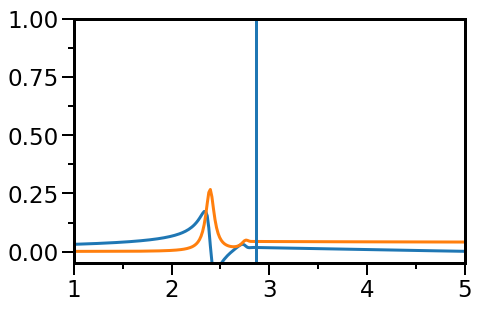

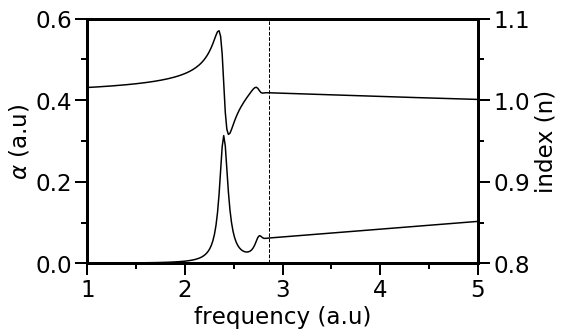

In [461]:
'plot alpha'
fig,ax=figure(figsize=(7,4.5))
ax.plot(f,np.real(Chi))
ax.set_xlim(1,5)
ax.set_ylim(-0.05,1)
ax.plot(f,np.imag(Chi))

ax.axvline(18/2/np.pi)

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure(figsize=(7,4.5))
ax1=ax.twinx()
minorTicker(ax1)

ax1.plot(f,n,color='k',linewidth=1.5)
ax.plot(f,alpha,color='k',linewidth=1.5)

ax.set_xlim(1,5)
ax1.set_ylim(0.8,1.1)
ax.set_ylim(0,0.6)

ax.axvline(18/2/np.pi,color='k',linewidth=1,linestyle='--')

ax.set_xlabel('frequency (a.u)')
ax.set_ylabel(r'$\alpha$ (a.u)')
ax1.set_ylabel('index (n)')

plt.savefig('excitons/exciton index 2e-2 tau3.pdf')

# np.save('excitons/tau3_tmax60_scale2e-2.npy',rho.P)

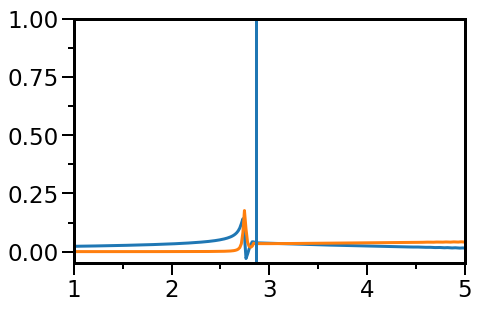

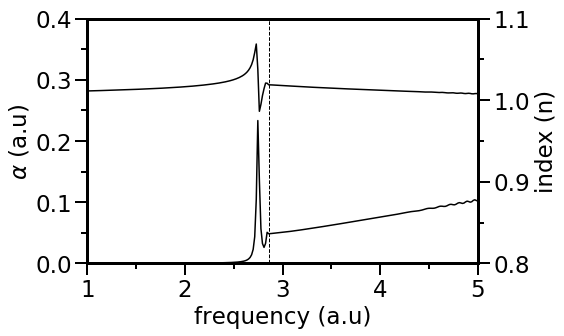

In [455]:
'plot alpha'
fig,ax=figure(figsize=(7,4.5))
ax.plot(f,np.real(Chi))
ax.set_xlim(1,5)
ax.set_ylim(-0.05,1)
ax.plot(f,np.imag(Chi))

ax.axvline(18/2/np.pi)

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure(figsize=(7,4.5))
ax1=ax.twinx()
minorTicker(ax1)

ax1.plot(f,n,color='k',linewidth=1.5)
ax.plot(f,alpha,color='k',linewidth=1.5)

ax.set_xlim(1,5)
ax1.set_ylim(0.8,1.1)
ax.set_ylim(0,0.4)

ax.axvline(18/2/np.pi,color='k',linewidth=1,linestyle='--')

ax.set_xlabel('frequency (a.u)')
ax.set_ylabel(r'$\alpha$ (a.u)')
ax1.set_ylabel('index (n)')

plt.savefig('excitons/exciton index scale1e-2 tau10.pdf')

np.save('excitons/tau10_tmax60_scale1e-2.npy',rho.P)

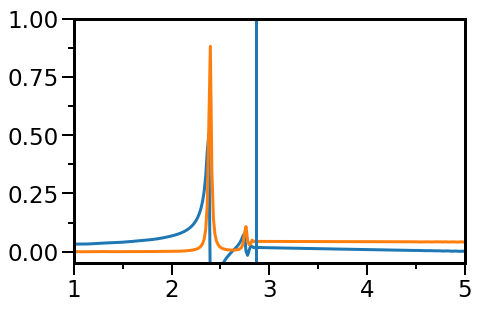

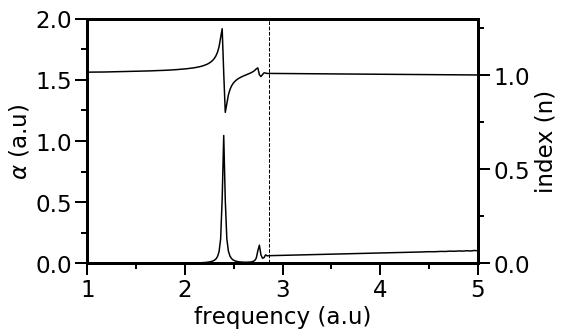

In [442]:
'plot alpha'
fig,ax=figure(figsize=(7,4.5))
ax.plot(f,np.real(Chi))
ax.set_xlim(1,5)
ax.set_ylim(-0.05,1)
ax.plot(f,np.imag(Chi))

ax.axvline(18/2/np.pi)

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure(figsize=(7,4.5))
ax1=ax.twinx()
minorTicker(ax1)

ax1.plot(f,n,color='k',linewidth=1.5)
ax.plot(f,alpha,color='k',linewidth=1.5)

ax.set_xlim(1,5)
ax1.set_ylim(0.,1.3)
ax.set_ylim(0,2)

ax.axvline(18/2/np.pi,color='k',linewidth=1,linestyle='--')

ax.set_xlabel('frequency (a.u)')
ax.set_ylabel(r'$\alpha$ (a.u)')
ax1.set_ylabel('index (n)')

# plt.savefig('excitons/exciton index scale2e-2 tau10.pdf')

# np.save('excitons/tau10_tmax60_scale2e-2.npy',rho.P)

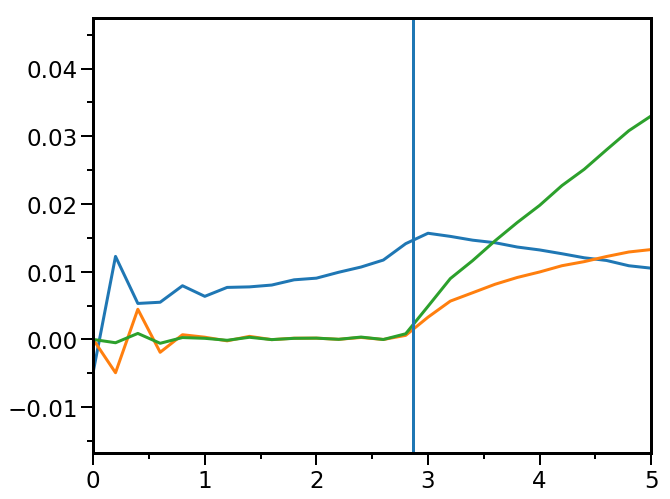

In [264]:
'dE+conjugate(P_renorm)'
'tmax=10, step=0.005'

# fig,ax=figure()
# ax.plot(t,rho.PEnv())

'calculate susceptibility'
Chi=np.conjugate(Pw/Ew)
# Chi=Pw/Ew

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

'plot alpha'
fig,ax=figure()
ax.plot(f,np.real(Chi))
ax.plot(f,np.imag(Chi))
ax.plot(f,alpha)
ax.set_xlim(0,5)
# ax.plot(f,np.absolute(Ew))

ax.axvline(18/2/np.pi)

# Non-interacting Semiconductor pol. and pop.

In [68]:
'scattering times'
tau1=10
tau2=1

'E-field for simulation'
tmin=-3
tmax=20
dt=.005
t=np.arange(tmin,tmax,dt)

np.seterr(under='ignore')
E=0.1*np.exp(-t*t)
w0=25
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))
Ew=fft.fftshift(fft.fft(np.real(E*np.exp(-1j*w0*t))))

'Density matrices'
k=np.linspace(0,7,5000)
Ek=k*k+18
d=np.ones(k.size)
DOS=k/100
rho=densityMatrix(t,Ek,d,DOS=DOS)

'step simulation'
for i in range(0,t.size-1):
    if i%500==0:
        print('step '+str(i)+'/'+str(t.size))
    update(rho,E,w0)
    
'calculate polarization'
Pt,Pw=rho.calcP(t,w0)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(E)/100,split=False)


step 0/4600
step 500/4600
step 1000/4600
step 1500/4600
step 2000/4600
step 2500/4600
step 3000/4600
step 3500/4600
step 4000/4600
step 4500/4600


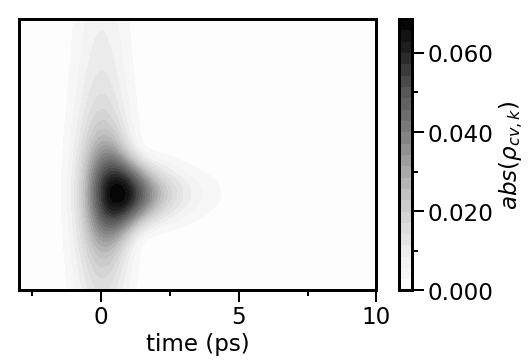

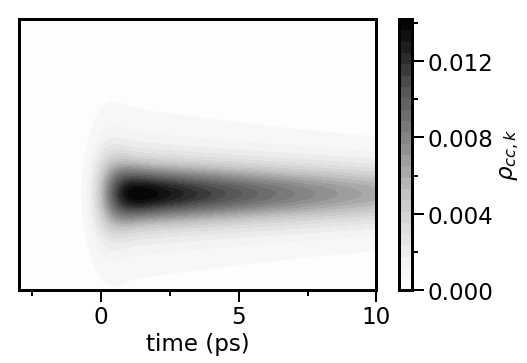

In [168]:
'Average polarization'
x,y,dat=adjAvg2D(Ekk,t,rho.P)
x,y,dat=adjAvg2D(x,y,dat)
x,y,dat=adjAvg2D(x,y,dat)
X,Y=np.meshgrid(y,x)


'plot polarization'
fig,ax=figure(figsize=(8,5))
levels=np.linspace(np.amin(np.absolute(dat)),np.amax(np.absolute(dat)),25)
cbar=ax.contourf(X,Y,np.absolute(dat),cmap='Greys',levels=levels)
cbar=plt.colorbar(cbar,format='%.3f')
cbar.set_ticks([0.0,0.02,0.04,0.06])
cbar.set_label(r'$abs(\rho_{cv,k})$')
ax.set_xlabel('time (ps)')
ax.set_yticks([])
ax.set_ylim(np.amin(x),6)
ax.set_xlim(np.amin(y),10)

'average density'
x,y,dat=adjAvg2D(Ekk,t,rho.fe)
x,y,dat=adjAvg2D(x,y,dat)
x,y,dat=adjAvg2D(x,y,dat)
X,Y=np.meshgrid(y,x)

plt.savefig('non interacting/polarization.pdf')

'plot density'
fig,ax=figure(figsize=(8,5))
levels=np.linspace(np.amin(np.absolute(dat)),np.amax(np.absolute(dat)),25)
cbar=ax.contourf(X,Y,np.absolute(dat),cmap='Greys',levels=levels)
cbar=plt.colorbar(cbar,format='%.3f')
cbar.set_ticks([0.0,0.004,0.008,0.012])
cbar.set_label(r'$\rho_{cc,k}$')

ax.set_xlabel('time (ps)')
ax.set_yticks([])
ax.set_ylim(np.amin(x),6)
ax.set_xlim(np.amin(y),10)

plt.savefig('non interacting/population.pdf')

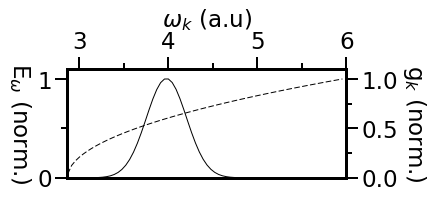

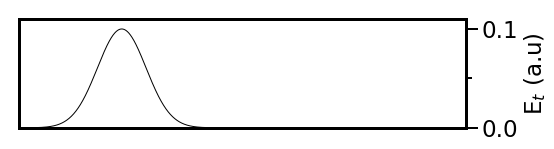

In [188]:
'plot Electric field spectrum'
fig,ax=figure(figsize=(5,2))
ax.plot(f,np.absolute(Ew)/np.amax(np.absolute(Ew)),color='k',linewidth=1)
ax.set_xlim(np.amin(x),6)
ax.set_ylim(0,1.1)
ax.set_ylabel(r'E$_\omega$ (norm.)',rotation=270,labelpad=30)
ax.xaxis.tick_top()
ax.set_xlabel(r'$\omega_k$ (a.u)')
ax.xaxis.set_label_position('top')
ax1=ax.twinx()
loc1=np.amin(np.where(f > np.amin(x)))
loc2=np.amin(np.where(f > 6))
DOS=np.sqrt(f[loc1:loc2]-np.amin(x))
DOS=DOS/np.amax(DOS)
ax1.plot(f[loc1:loc2],DOS,linestyle='--',color='k',linewidth=1)
ax1.set_xlim(np.amin(x),6)
ax1.set_ylim(0,1.1)
ax1.set_yticks([0,0.5,1])
ax1.set_ylabel('g$_k$ (norm.)',rotation=270,labelpad=30)


plt.savefig('non interacting/Ew.pdf')

fig,ax=figure(figsize=(8,2))
ax.set_yticks([])
ax.set_xticks([])
ax=ax.twinx()
ax.plot(t,E,color='k',linewidth=1)

ax.set_xlim(np.amin(y),10)
ax.set_ylim(0,0.11)
# ax.set_xticks([])
ax.set_ylabel(r'E$_t$ (a.u)')
# ax.yaxis.set_label_position('right')

plt.savefig('non interacting/Et.pdf')

# Semiconductor linear response

In [170]:
'scattering times'
tau1=10
tau2=10

'E-field for simulation'
tmin=-3
tmax=40
dt=.005
t=np.arange(tmin,tmax,dt)

np.seterr(under='ignore')
E=0.001*np.exp(-15*t*t)
w0=15
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))
Ew=fft.fftshift(fft.fft(np.real(E*np.exp(-1j*w0*t))))

'Density matrices'
k=np.linspace(0,7,400)
Ek=k*k+18
d=np.ones(k.size)
DOS=k*k/100
rho=densityMatrix(t,Ek,d,DOS=DOS)

'step simulation'
for i in range(0,t.size-1):
    if i%500==0:
        print('step '+str(i)+'/'+str(t.size))
    update(rho,E,w0)
    
'calculate polarization'
Pt,Pw=rho.calcP(t,w0)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(E)/100,split=False)


step 0/8600
step 500/8600
step 1000/8600
step 1500/8600
step 2000/8600
step 2500/8600
step 3000/8600
step 3500/8600
step 4000/8600
step 4500/8600
step 5000/8600
step 5500/8600
step 6000/8600
step 6500/8600
step 7000/8600
step 7500/8600
step 8000/8600
step 8500/8600


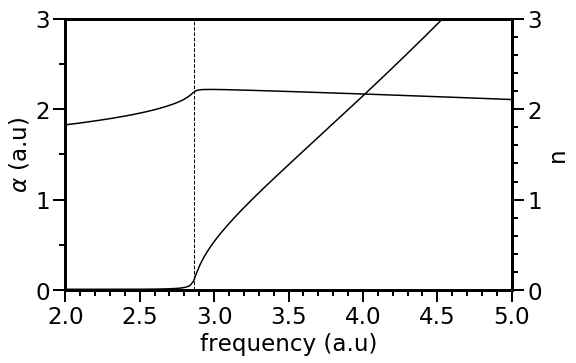

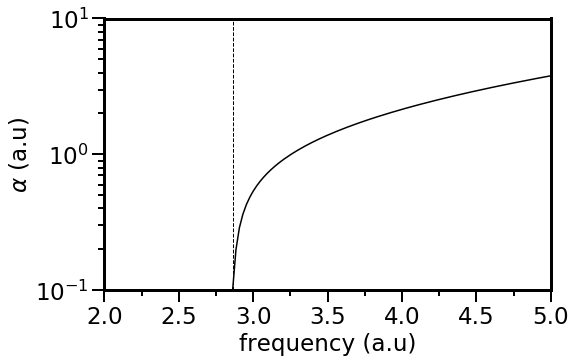

In [171]:
'center frequency 25, exp(-30*t*t)'

# def chi(w,w0,tau,scale):

'calculation of background dielectric function (not used currently)'
c1,c2=chi(f,6.0,10,15000)
eps=1+c1+1j*c2

'calculate susceptibility'
Chi=np.conjugate(Pw/Ew)

'scale background dielectric function (not used)'
loc=np.amin(np.where(np.real(Chi)==np.amax(np.real(Chi))))
eps=eps/(np.real(eps[loc]))*np.real(Chi[loc])

'calculated n, k, and alpha'
n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

'plot n and alpha'
fig,ax1=figure(figsize=(8,5))
ax=ax1.twinx()
ax.plot(f,n,color='k',linewidth=1.5)
ax1.plot(f,alpha,color='k',linewidth=1.5)
ax.axvline(18/2/np.pi,linestyle='--',linewidth=1,color='k')

ax.set_xlim(2,5)
ax1.set_ylim(0,3)
ax.set_ylim(0,3)
ax1.set_xlabel('frequency (a.u)')
ax.set_ylabel('n')
ax1.set_ylabel(r'$\alpha$ (a.u)')

plt.savefig('non interacting/index.pdf')

'plot n and alpha'
fig,ax=figure(figsize=(8,5))
# ax.plot(f,n,color='k',linewidth=1.5)
# ax1=ax.twinx()
ax.plot(f,alpha,color='k',linewidth=1.5)
ax.axvline(18/2/np.pi,linestyle='--',linewidth=1,color='k')
# ax.set_yticks([])

ax.set_xlim(2,5)
ax.set_yscale('log')

ax.set_ylim(10**-1,10**1)

ax.set_xlabel('frequency (a.u)')
ax.set_ylabel(r'$\alpha$ (a.u)')

plt.savefig('non interacting/index2.pdf')

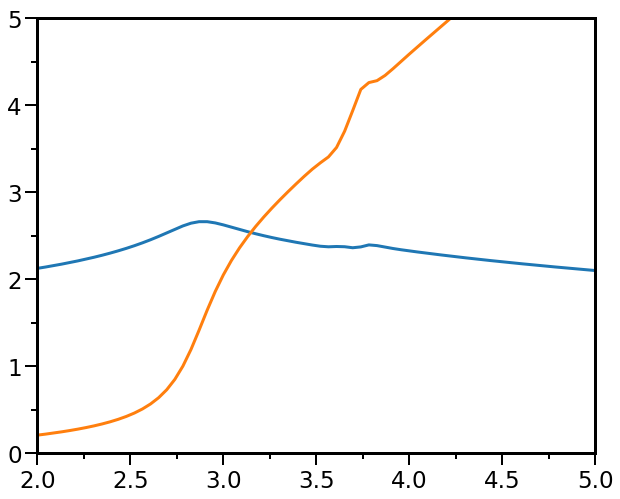

In [215]:
'center frequency 30, exp(-t*t)'

# def chi(w,w0,tau,scale):
    
c1,c2=chi(f,6.0,10,15000)
eps=1+c1+1j*c2

Chi=np.conjugate(Pw/Ew)

loc=np.amin(np.where(np.real(Chi)==np.amax(np.real(Chi))))
eps=eps/(np.real(eps[loc]))*np.real(Chi[loc])



ax.plot(f,1+np.real(Chi))

n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure()
ax.plot(f,n)
ax.plot(f,alpha)

ax.set_xlim(2,5)

x0=2.7
x=np.linspace(x0,8,100)
y=np.sqrt(x-x0)
# ax.plot(x,y*45)

# ax.set_yscale('log')
ax.set_ylim(0,5)

f3=f
n3=n
alpha3=alpha

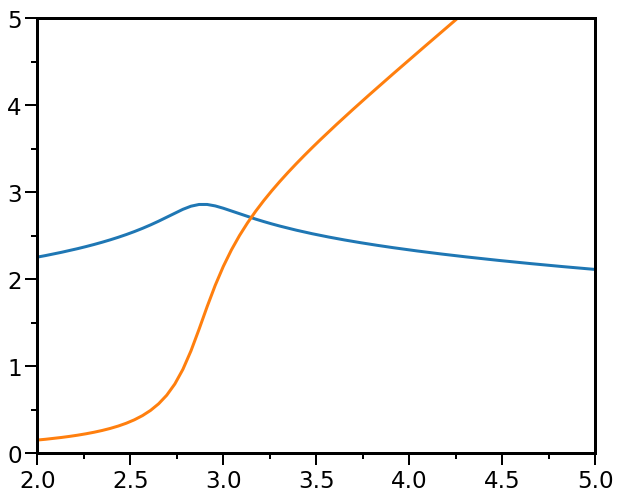

In [209]:
'center frequency 30, exp(-25*t*t)'
# def chi(w,w0,tau,scale):
    
c1,c2=chi(f,6.0,10,15000)
eps=1+c1+1j*c2

Chi=np.conjugate(Pw/Ew)

loc=np.amin(np.where(np.real(Chi)==np.amax(np.real(Chi))))
eps=eps/(np.real(eps[loc]))*np.real(Chi[loc])



ax.plot(f,1+np.real(Chi))

n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure()
ax.plot(f,n)
ax.plot(f,alpha)

ax.set_xlim(2,5)

x0=2.7
x=np.linspace(x0,8,100)
y=np.sqrt(x-x0)
# ax.plot(x,y*45)

# ax.set_yscale('log')
ax.set_ylim(0,5)

f2=f
n2=n
alpha2=alpha

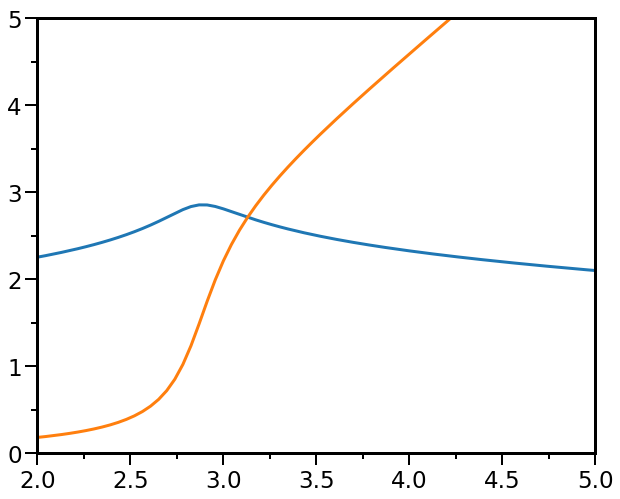

In [211]:
'center frequency 20, exp(-25*t*t)'
# def chi(w,w0,tau,scale):
    
c1,c2=chi(f,6.0,10,15000)
eps=1+c1+1j*c2

Chi=np.conjugate(Pw/Ew)

loc=np.amin(np.where(np.real(Chi)==np.amax(np.real(Chi))))
eps=eps/(np.real(eps[loc]))*np.real(Chi[loc])



ax.plot(f,1+np.real(Chi))

n=np.sqrt(1+Chi)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure()
ax.plot(f,n)
ax.plot(f,alpha)

ax.set_xlim(2,5)

x0=2.7
x=np.linspace(x0,8,100)
y=np.sqrt(x-x0)
# ax.plot(x,y*45)

# ax.set_yscale('log')
ax.set_ylim(0,5)

f1=f
n1=n
alpha1=alpha

(2, 5)

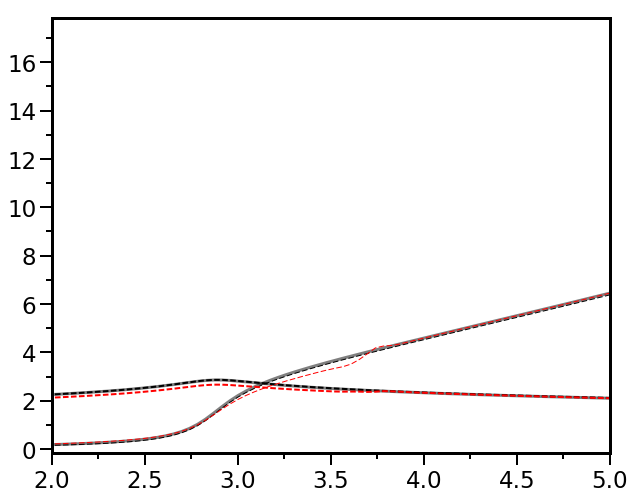

In [218]:
fig,ax=figure()
ax.plot(f1,n1,color='k',alpha=0.5)
ax.plot(f1,alpha1,color='k',alpha=0.5)

ax.plot(f2,n2,color='k',linestyle='--',linewidth=2)
ax.plot(f2,alpha2,color='k',linestyle='--',linewidth=1)

ax.plot(f3,n3,color='r',linestyle='--',linewidth=2)
ax.plot(f3,alpha3,color='r',linestyle='--',linewidth=1)

ax.set_xlim(2,5)

(0, 5)

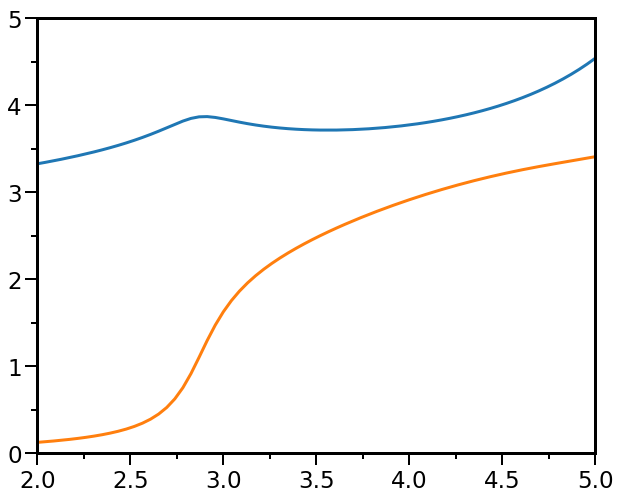

In [195]:
# def chi(w,w0,tau,scale):
    
c1,c2=chi(f,6.0,10,15000)
eps=1+c1+1j*c2

Chi=np.conjugate(Pw/Ew)

loc=np.amin(np.where(np.real(Chi)==np.amax(np.real(Chi))))
eps=eps/(np.real(eps[loc]))*np.real(Chi[loc])



ax.plot(f,1+np.real(Chi))

n=np.sqrt(1+Chi+eps)
k=np.imag(n)
alpha=k*f
n=np.real(n)

fig,ax=figure()
ax.plot(f,n)
ax.plot(f,alpha)

ax.set_xlim(2,5)

x0=2.7
x=np.linspace(x0,8,100)
y=np.sqrt(x-x0)
# ax.plot(x,y*45)

# ax.set_yscale('log')
ax.set_ylim(0,5)


# index of refraction

/opt/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


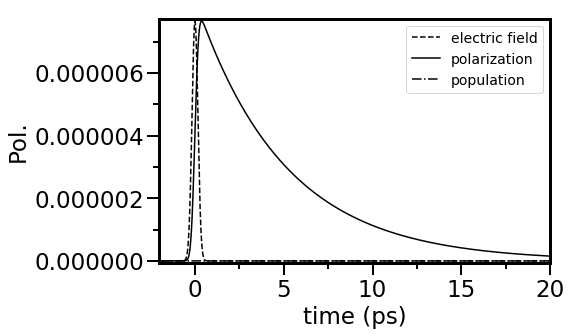

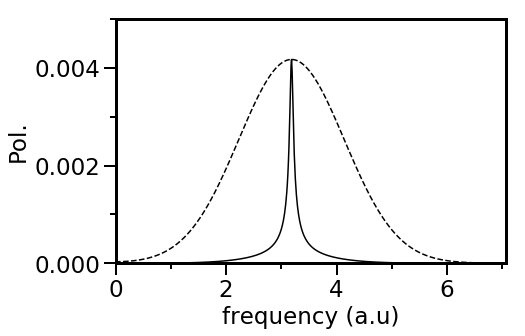

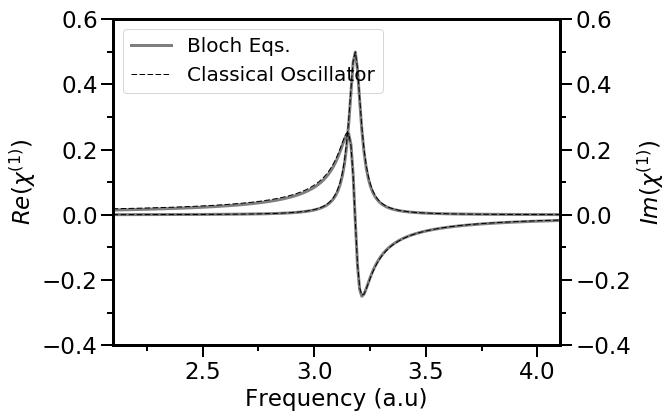

In [77]:
'Two-level system simulation'
tau1=5
tau2=5
'scattering functions (const. rate)'
def pScat(rho,i):
    return -rho.P[:,i]/tau2
def feScat(rho,i):
    return -rho.fe[:,i]/tau1
def fhScat(rho,i):
    return -rho.fe[:,i]/tau1

'scattering times'
tmin=-3
tmax=100
dt=.005

'simulation parameters (field and time-grid)'
t=np.arange(tmin,tmax,dt)
np.seterr(under='ignore')
w0=20   # center frequency
E=0.0002*np.exp(-18*t*t)  # Gaussian enevelope
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))  # frequencies
Ew=fft.fftshift(fft.fft(np.real(E*np.exp(1j*w0*t))))  # E-field spectrum

'System parameters'
Ek=np.zeros(1)+20
d=np.zeros(1)+0.1
rho=densityMatrix(t,Ek,d)

'Run Simulation'
for i in range(0,t.size-1):
    update(rho,E,w0)

'calculate polarization and susceptibility'
rho.calcP(t,w0)
# f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=0.001)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(E)/100,split=False)
Chi=np.conjugate(Pw/Ew)
# Chi=Pw/Ew
chi1=np.real(Chi)   # from simulation
chi2=np.imag(Chi)   # from simulation
c1,c2=chi(f,w0/2/np.pi,15,np.amax(chi2))   # from Lorentz oscillator

'plot time dependent polarization'
fig,ax=figure(figsize=(7,4.5))
ax.plot(t,E/np.amax(E)*np.amax(rho.PEnv()),label='electric field',color='k',linewidth=1.5,linestyle='--')
ax.plot(t,rho.PEnv(),color='k',linewidth=1.5,linestyle='-',label='polarization')
ax.plot(t,rho.fe[0,:],color='k',linewidth=1.5,linestyle='-.',label='population')
ax.set_xlabel('time (ps)')
ax.set_ylabel('Pol.')
ax.set_xlim(-2,20)
ax.legend(fontsize=14)

plt.savefig('2 level system/polarization response.pdf')


'plot frequency domain polarization and field'
fig,ax=figure(figsize=(7,4.5))
ax.plot(f,np.absolute(Ew)/np.amax(np.absolute(Ew))*np.amax(np.absolute(Pw)),color='k',linestyle='--',linewidth=1.5,label='electric field')
ax.plot(f,np.absolute(Pw),color='k',linestyle='-',linewidth=1.5,label='polarization')

# decorate figure
ax.set_xlabel('frequency (a.u)')
ax.set_ylabel('Pol.')
ax.set_xlim(0,np.amax(f))
ax.set_ylim(0,np.amax(np.absolute(Pw))*1.2)

# ax.legend()

plt.savefig('2 level system/frequency domain.pdf')


'plot susceptibility'
fig,ax=figure(figsize=(8,6))
ax1=ax.twinx()
minorTicker(ax1)
# simulation
ax.plot(f,chi1,label=r'Bloch Eqs.',color='k',alpha=0.5)
ax1.plot(f,chi2,color='k',alpha=0.5)
# lorentz oscillator
ax.plot(f,c1,color='k',linestyle='--',linewidth=1,label='Classical Oscillator')
ax1.plot(f,c2,color='k',linestyle='--',linewidth=1)

# decorate figure
ax.set_ylim(-0.4,0.6)
ax1.set_ylim(-0.4,0.6)
ax.set_xlabel('Frequency (a.u)')
ax.set_ylabel(r'$Re(\chi^{(1)})$')
ax.set_xlim(2.1,4.1)
ax.legend(loc=2)

ax1.set_ylabel(r'$Im(\chi^{(1)})$')

In [195]:
'Two-level system simulation low damping'
tau1=5
tau2=15

'simulation parameters (field and time-grid)'
tmin=-3
tmax=200
dt=.005
t=np.arange(tmin,tmax,dt)
np.seterr(under='ignore')
w0=20   # center frequency
E=0.0002*np.exp(-18*t*t)  # Gaussian enevelope
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))  # frequencies
Ew=fft.fftshift(fft.fft(np.real(E*np.exp(1j*w0*t))))  # E-field spectrum

'System parameters'
Ek=np.zeros(1)+20
d=np.zeros(1)+0.1
rho=densityMatrix(t,Ek,d)

'Run Simulation'
for i in range(0,t.size-1):
    update(rho,E,w0)

'calculate polarization and susceptibility'
rho.calcP(t,w0)
# f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=0.001)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(E)/100,split=False)
Chi=np.conjugate(Pw/Ew)
# Chi=Pw/Ew
chi11=np.real(Chi)   # from simulation
chi21=np.imag(Chi)   # from simulation
c11,c21=chi(f,w0/2/np.pi,45,np.amax(chi21))   # from Lorentz oscillator





'Two-level system simulation medium damping'
tau1=5
tau2=10

'simulation parameters (field and time-grid)'
np.seterr(under='ignore')
w0=20   # center frequency
E=0.0002*np.exp(-18*t*t)  # Gaussian enevelope
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))  # frequencies
Ew=fft.fftshift(fft.fft(np.real(E*np.exp(1j*w0*t))))  # E-field spectrum

'System parameters'
Ek=np.zeros(1)+20
d=np.zeros(1)+0.1
rho=densityMatrix(t,Ek,d)

'Run Simulation'
for i in range(0,t.size-1):
    update(rho,E,w0)

'calculate polarization and susceptibility'
rho.calcP(t,w0)
# f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=0.001)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(E)/100,split=False)
Chi=np.conjugate(Pw/Ew)
# Chi=Pw/Ew
chi12=np.real(Chi)   # from simulation
chi22=np.imag(Chi)   # from simulation
c12,c22=chi(f,w0/2/np.pi,30,np.amax(chi22))   # from Lorentz oscillator




'Two-level system simulation high damping'
tau1=5
tau2=5

'simulation parameters (field and time-grid)'
np.seterr(under='ignore')
w0=20   # center frequency
E=0.0002*np.exp(-18*t*t)  # Gaussian enevelope
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))  # frequencies
Ew=fft.fftshift(fft.fft(np.real(E*np.exp(1j*w0*t))))  # E-field spectrum

'System parameters'
Ek=np.zeros(1)+20
d=np.zeros(1)+0.1
rho=densityMatrix(t,Ek,d)

'Run Simulation'
for i in range(0,t.size-1):
    update(rho,E,w0)

'calculate polarization and susceptibility'
rho.calcP(t,w0)
# f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=0.001)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(E)/100,split=False)
Chi=np.conjugate(Pw/Ew)
# Chi=Pw/Ew
chi13=np.real(Chi)   # from simulation
chi23=np.imag(Chi)   # from simulation
c13,c23=chi(f,w0/2/np.pi,15,np.amax(chi23))   # from Lorentz oscillator


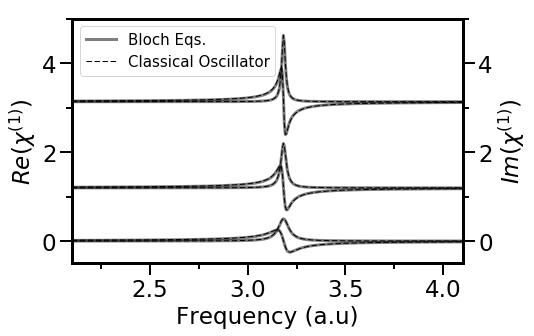

In [202]:
'Plotting figure for tau dependence'
fig,ax=figure(figsize=(7,4.5))
ax1=ax.twinx()
minorTicker(ax1)

offset=0
offset2=np.amax(chi23)-np.amin(chi12)+0.2
offset1=np.amax(chi22)-np.amin(chi11)+0.2+offset2

'Plot low damping'
# simulation
ax.plot(f,chi11+offset1,label=r'Bloch Eqs.',color='k',alpha=0.5)
ax1.plot(f,chi21+offset1,color='k',alpha=0.5)
# lorentz oscillator
ax.plot(f,c11+offset1,color='k',linestyle='--',linewidth=1,label='Classical Oscillator')
ax1.plot(f,c21+offset1,color='k',linestyle='--',linewidth=1)

'Plot medium damping'
# simulation
ax.plot(f,chi12+offset2,color='k',alpha=0.5)
ax1.plot(f,chi22+offset2,color='k',alpha=0.5)
# lorentz oscillator
ax.plot(f,c12+offset2,color='k',linestyle='--',linewidth=1)
ax1.plot(f,c22+offset2,color='k',linestyle='--',linewidth=1)

'Plot high damping'
# simulation
ax.plot(f,chi13+offset,color='k',alpha=0.5)
ax1.plot(f,chi23+offset,color='k',alpha=0.5)
# lorentz oscillator
ax.plot(f,c13+offset,color='k',linestyle='--',linewidth=1)
ax1.plot(f,c23+offset,color='k',linestyle='--',linewidth=1)

# decorate figure
ymin=-0.5
ymax=5
ax1.set_ylim(ymin,ymax)
ax.set_ylim(ymin,ymax)
ax.set_xlabel('Frequency (a.u)')
ax.set_ylabel(r'$Re(\chi^{(1)})$')
ax.set_xlim(2.1,4.1)
ax.legend(loc=2,fontsize=15)
ax1.set_ylabel(r'$Im(\chi^{(1)})$')

plt.savefig('2 level system/susceptibility.pdf')

# Two-level system pop. and pol. 1

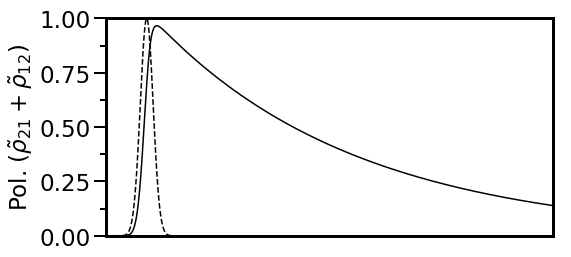

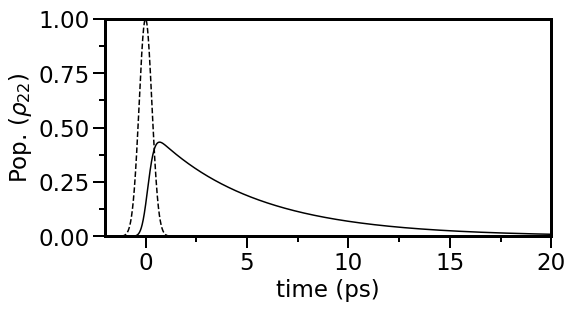

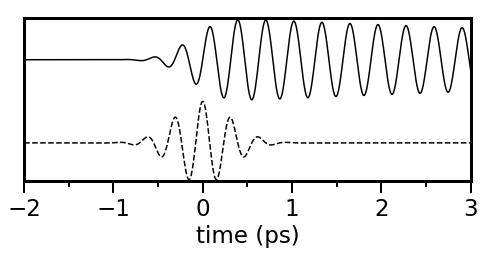

In [50]:
'Two-level system simulation'
tau1=5
tau2=2*tau1
'scattering functions (const. rate)'
def pScat(rho,i):
    return -rho.P[:,i]/tau2
def feScat(rho,i):
    return -rho.fe[:,i]/tau1
def fhScat(rho,i):
    return -rho.fe[:,i]/tau1

'scattering times'
tmin=-3
tmax=60
dt=.005

'simulation parameters (field and time-grid)'
t=np.arange(tmin,tmax,dt)
np.seterr(under='ignore')
w0=20
E=1*np.exp(-5*t*t)  # Gaussian enevelope

'''
E=np.zeros(t.size)   # square wave
E=np.ones(t.size)
E[0:t.size/5]=0
E=-E
'''

Ek=np.zeros(1)+20
d=np.zeros(1)+1
rho=densityMatrix(t,Ek,d)

for i in range(0,t.size-1):
    update(rho,E,w0)
    
    
rho.P[0,:]=rho.P[0,:]*np.exp(-1j*w0*t)
# Pt=rho.P[0,:]+np.conjugate(rho.P[0,:])
Pt=rho.P[0,:]+np.conjugate(rho.P[0,:])

fig,ax=figure(figsize=(8,4))
ax.plot(t,E/np.amax(E),color='k',linewidth=1.5,linestyle='--')
ax.plot(t,np.absolute(sgn.hilbert(np.real(Pt))),color='k',linestyle='-',linewidth=1.5)
ax.set_ylabel(r'Pol. ($\tilde{\rho}_{21}+\tilde{\rho}_{12}$)')
ax.set_xticks([])
ax.set_ylim(0,1.0)
ax.set_xlim(-2,20)

plt.savefig('2 level system/polarization1.pdf')

fig,ax=figure(figsize=(8,4))
ax.plot(t,np.absolute(rho.fe[0,:]),color='k',linewidth=1.5)
ax.plot(t,E/np.amax(E),color='k',linewidth=1.5,linestyle='--')
ax.set_xlabel('time (ps)')
ax.set_ylabel(r'Pop. ($\rho_{22}$)')
ax.set_ylim(0,1.0)
ax.set_xlim(-2,20)

plt.savefig('2 level system/population1.pdf')

fig,ax=figure(figsize=(8,3))
ax.plot(t,np.real(Pt)+0.5,color='k',linestyle='-',linewidth=1.5)
ax.plot(t,E/np.amax(E)*np.cos(w0*t)-1.5,color='k',linestyle='--',linewidth=1.5)
ax.set_xlim(-2,3)
ax.set_yticks([])
ax.set_xlabel('time (ps)')

plt.savefig('2 level system/inset1.pdf')

# Two-level system pop. and pol. 2

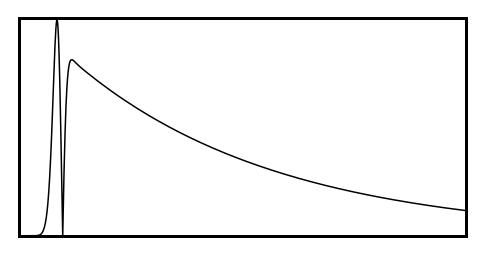

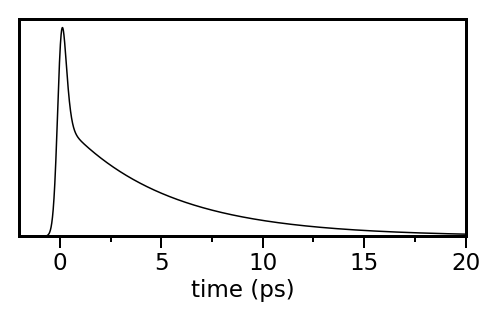

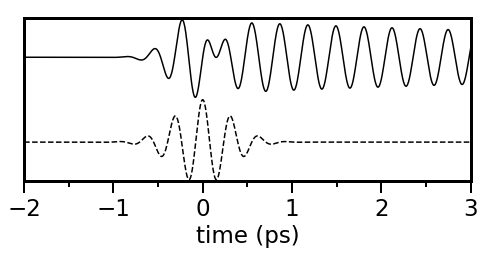

In [227]:
'Two-level system simulation'
tau1=5
tau2=2*tau1
'scattering functions (const. rate)'
def pScat(rho,i):
    return -rho.P[:,i]/tau2
def feScat(rho,i):
    return -rho.fe[:,i]/tau1
def fhScat(rho,i):
    return -rho.fe[:,i]/tau1

'scattering times'
tmin=-3
tmax=60
dt=.005

'simulation parameters (field and time-grid)'
t=np.arange(tmin,tmax,dt)
np.seterr(under='ignore')
w0=20
E=3*np.exp(-5*t*t)  # Gaussian enevelope

'''
E=np.zeros(t.size)   # square wave
E=np.ones(t.size)
E[0:t.size/5]=0
E=-E
'''

Ek=np.zeros(1)+20
d=np.zeros(1)+1
rho=densityMatrix(t,Ek,d)

for i in range(0,t.size-1):
    update(rho,E,w0)
    
    
rho.P[0,:]=rho.P[0,:]*np.exp(-1j*w0*t)
# Pt=rho.P[0,:]+np.conjugate(rho.P[0,:])
Pt=rho.P[0,:]+np.conjugate(rho.P[0,:])

fig,ax=figure(figsize=(8,4))
# ax.plot(t,E/np.amax(E)/2,color='k',linewidth=1.5,linestyle='--')
ax.plot(t,np.absolute(sgn.hilbert(np.real(Pt))),color='k',linestyle='-',linewidth=1.5)
# ax.set_ylabel(r'Pol. ($\tilde{\rho}_{21}+\tilde{\rho}_{12}$)')
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(0,1.0)
ax.set_xlim(-2,20)

plt.savefig('2 level system/polarization2.pdf')

fig,ax=figure(figsize=(8,4))
ax.plot(t,np.absolute(rho.fe[0,:]),color='k',linewidth=1.5)
ax.set_xlabel('time (ps)')
# ax.set_ylabel(r'Pop. ($\rho_{22}$)')
ax.set_yticks([])
ax.set_ylim(0,1.0)
ax.set_xlim(-2,20)

plt.savefig('2 level system/population2.pdf')

fig,ax=figure(figsize=(8,3))
ax.plot(t,np.real(Pt)+0.5,color='k',linestyle='-',linewidth=1.5)
ax.plot(t,E/np.amax(E)*np.cos(w0*t)-1.5,color='k',linestyle='--',linewidth=1.5)
ax.set_xlim(-2,3)
ax.set_yticks([])
ax.set_xlabel('time (ps)')

plt.savefig('2 level system/inset2.pdf')

# Two-level system pop. and pol. 3

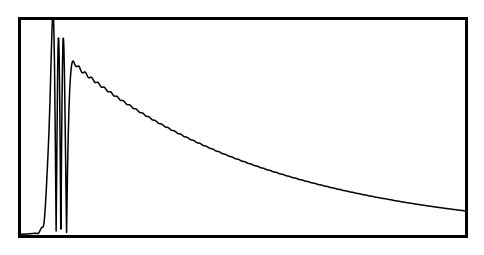

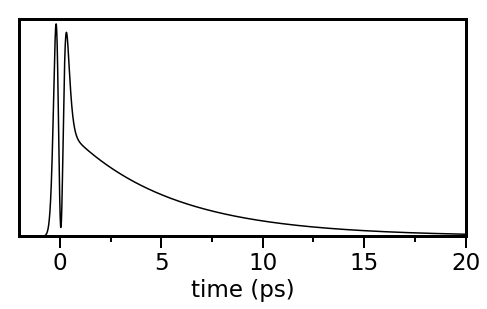

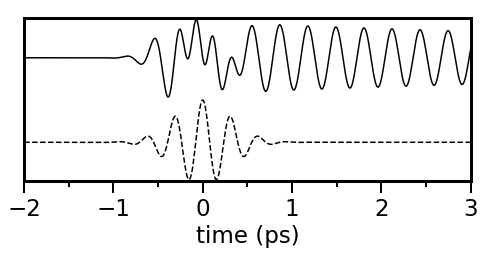

In [228]:
'Two-level system simulation'
tau1=5
tau2=2*tau1
'scattering functions (const. rate)'
def pScat(rho,i):
    return -rho.P[:,i]/tau2
def feScat(rho,i):
    return -rho.fe[:,i]/tau1
def fhScat(rho,i):
    return -rho.fe[:,i]/tau1

'scattering times'
tmin=-3
tmax=60
dt=.005

'simulation parameters (field and time-grid)'
t=np.arange(tmin,tmax,dt)
np.seterr(under='ignore')
w0=20
E=7*np.exp(-5*t*t)  # Gaussian enevelope

'''
E=np.zeros(t.size)   # square wave
E=np.ones(t.size)
E[0:t.size/5]=0
E=-E
'''

Ek=np.zeros(1)+20
d=np.zeros(1)+1
rho=densityMatrix(t,Ek,d)

for i in range(0,t.size-1):
    update(rho,E,w0)
    
    
rho.P[0,:]=rho.P[0,:]*np.exp(-1j*w0*t)
# Pt=rho.P[0,:]+np.conjugate(rho.P[0,:])
Pt=rho.P[0,:]+np.conjugate(rho.P[0,:])

fig,ax=figure(figsize=(8,4))
# ax.plot(t,E/np.amax(E)/2,color='k',linewidth=1.5,linestyle='--')
ax.plot(t,np.absolute(sgn.hilbert(np.real(Pt))),color='k',linestyle='-',linewidth=1.5)
# ax.set_ylabel(r'Pol. ($\tilde{\rho}_{21}+\tilde{\rho}_{12}$)')
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim(0,1.0)
ax.set_xlim(-2,20)

plt.savefig('2 level system/polarization3.pdf')

fig,ax=figure(figsize=(8,4))
ax.plot(t,np.absolute(rho.fe[0,:]),color='k',linewidth=1.5)
ax.set_xlabel('time (ps)')
# ax.set_ylabel(r'Pop. ($\rho_{22}$)')
ax.set_yticks([])
ax.set_ylim(0,1.0)
ax.set_xlim(-2,20)

plt.savefig('2 level system/population3.pdf')

fig,ax=figure(figsize=(8,3))
ax.plot(t,np.real(Pt)+0.5,color='k',linestyle='-',linewidth=1.5)
ax.plot(t,E/np.amax(E)*np.cos(w0*t)-1.5,color='k',linestyle='--',linewidth=1.5)
ax.set_xlim(-2,3)
ax.set_yticks([])
ax.set_xlabel('time (ps)')

plt.savefig('2 level system/inset3.pdf')

0.499079630788


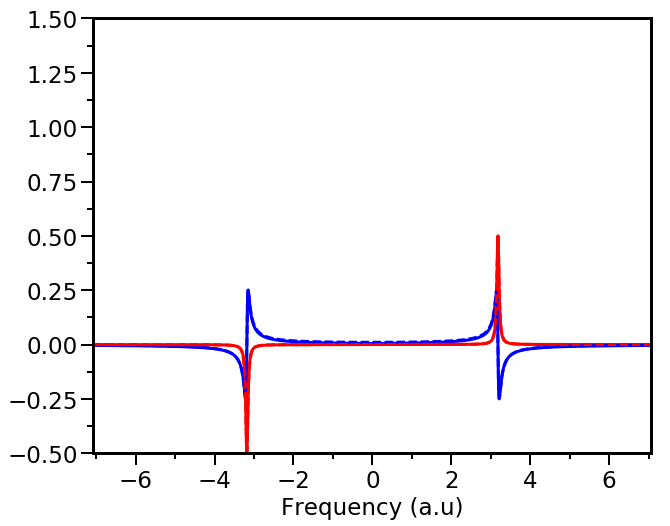

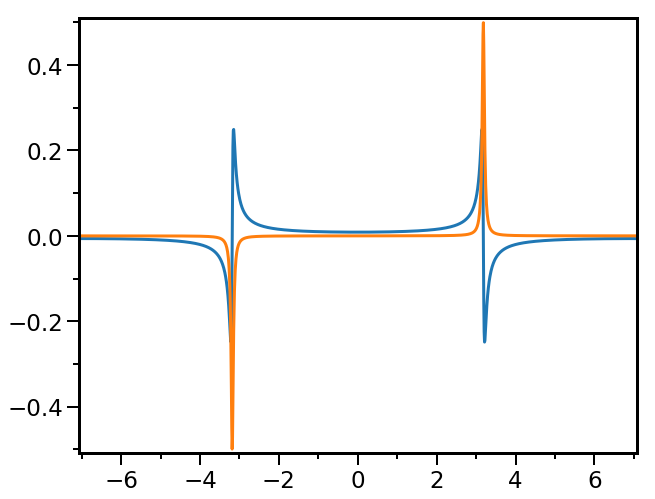

In [120]:
'Testing Kramers-Kronig'
fig,ax=figure()
ax.plot(f,chi1,label=r'Re($\chi$)',color='b')
ax.plot(f,chi2,label=r'Im($\chi$)',color='r')

ax.set_xlabel('Frequency (a.u)')
ax.set_ylabel('')

# ax.set_xlim(2.1,4.1)

print(np.amax(chi2))
c1,c2=chi(f,w0/2/np.pi,15,np.amax(chi2))

ax.plot(f,c1,color='b',linestyle='--')
ax.plot(f,c2,color='r',linestyle='--')
ax.set_ylim(-0.5,1.5)


c1=-np.imag(sgn.hilbert(c2))

fig,ax=figure()
ax.plot(f,c1)
ax.plot(f,c2)

[[  0.00000000e+000 +0.00000000e+000j  -4.18758132e-107 +1.85337865e-105j
   -2.22892763e-106 +5.76472057e-105j ...,
   -6.35348381e-010 -3.17398448e-009j  -4.75683361e-010 -3.20017152e-009j
   -3.14989440e-010 -3.21833683e-009j]
 [  0.00000000e+000 +0.00000000e+000j   4.18758132e-107 +1.85337865e-105j
    2.22892763e-106 +5.76472057e-105j ...,
    6.35348381e-010 -3.17398448e-009j   4.75683361e-010 -3.20017152e-009j
    3.14989440e-010 -3.21833683e-009j]]


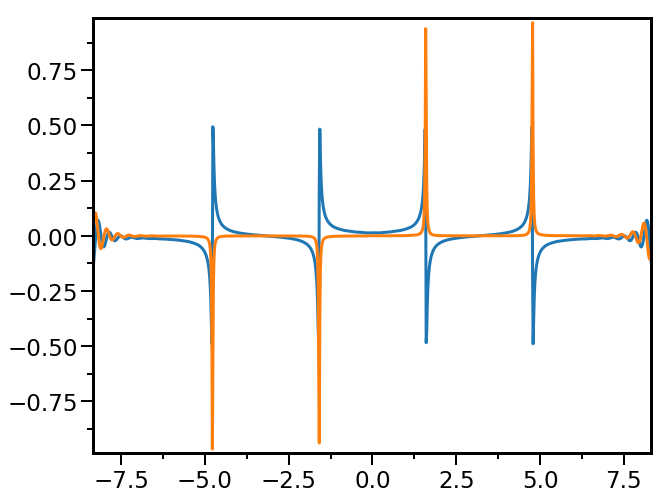

In [131]:
'Extracting the susceptibility for two modes'
'used for testing new polarization summation'
tau1=5
tau2=10

'scattering times'
tmin=-3
tmax=60
dt=.005

'simulation parameters (field and time-grid)'
t=np.arange(tmin,tmax,dt)
np.seterr(under='ignore')
w0=20
E=0.0001*np.exp(-25*t*t)  # Gaussian enevelope
Ew=fft.fftshift(fft.fft(np.real(E*np.exp(1j*w0*t))))
f=fft.fftshift(fft.fftfreq(t.size,t[1]-t[0]))


Ek=np.zeros(2)
d=np.zeros(2)+0.1

DOS=np.zeros(2)+1
DOS[1]=1
Ek[0]=10
Ek[1]=30
rho=densityMatrix(t,Ek,d,DOS=DOS)

for i in range(0,t.size-1):
    update(rho,E,w0)
print(rho.P)

Pt,Pw=rho.calcP(t,w0)
f,Ew,Pw=trim(f,Ew,rho.Pw,Emin=np.amax(E)/1000,split=False)

Chi=np.conjugate(Pw/Ew)
# Chi=Pw/Ew
chi11=np.real(Chi)   # from simulation
chi21=np.imag(Chi)   # from simulation
c11,c21=chi(f,w0/2/np.pi,45,np.amax(chi21))   # from Lorentz oscillator

fig,ax=figure()
ax.plot(f,chi11)
ax.plot(f,chi21)

In [82]:
'testing cythonized-coulomb calculation'

%%cython --annotate

from libc.math cimport cos
from libc.stdlib cimport malloc, free
import numpy as np
cdef double* coulomb( k,rho):
    cdef int i
    cdef int jmax=k.size
    
    cdef int imax=100
    cdef double[100] cosTheta

    cdef double *integral = <double *>malloc(jmax * sizeof(double))
#     cdef double *kk = <double *>malloc(jmax * sizeof(double))
#     for i in range(jmax):
#         kk[i]=k[i]*k[i]
    kk=k*k

    cdef int j
    for j in range(jmax):
        if j%500==0:
            print('step '+str(j)+' out of '+str(k.size))
        integral[j]=np.sum(rho[0:j]/(kk[j]+kk[0:j]-2*k[j]*k[:j]))
        integral[j]=integral[j]+np.sum(rho[j+1:]/(kk[j]+kk[j+1:]-2*k[j]*k[j+1:]))
        for i in range(1,100):
            integral[j]=integral[j]+np.sum(rho/(kk[j]+kk-2*k[j]*k*cos(3.14159/100.)))

    return integral

cdef double* Sum1(rho,kk,j):
    for 